In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# File feltöltés (csak colab-nál kell)
import os
from google.colab import files
import shutil

new_folder = "videos"

if os.path.isdir(new_folder):
  shutil.rmtree(new_folder)

os.mkdir(new_folder)

uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(new_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving sample.mp4 to sample.mp4
move sample.mp4 to videos/sample.mp4


In [ ]:
# ezek a paraméterek manuálisan be vannak állítva, így nem kell mindig 
# a cv2.VideoCapture-től lekérni
WIDTH = 1280
HEIGHT = 720
FPS = 30

# átlag kép a teljes videóra
def create_avg_image_1(path):
  capture = cv2.VideoCapture(path)
  avg_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avg_image += gray
  return avg_image / np.max(avg_image) * 255

# átlag kép start_frame és end_frame között
def create_avg_image_3(path, start_frame, end_frame):
  capture = cv2.VideoCapture(path, cv2.IMREAD_GRAYSCALE)
  capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
  avg_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(end_frame - start_frame):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avg_image += gray
  return avg_image / np.max(avg_image) * 255

# színes átlagkép a teljes videóra
def create_avg_colored_image_1(path):
  capture = cv2.VideoCapture(path)
  avg_image = np.zeros((HEIGHT, WIDTH, 3), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    avg_image += frame
  return avg_image / np.max(avg_image) * 255

# star trail készítése (http://www.tobias-westmeier.de/astronomy_tutorial_startrails.php)
def create_star_trail(path):
  capture = cv2.VideoCapture(path)
  trail = np.zeros((HEIGHT, WIDTH, 3), dtype='uint8')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    np.maximum(frame, trail, out=trail)
  return trail

# kiemeli a kép azon részeit amelyek az átlag alapján kiugró értéknek számítanak
def get_highlighted_image_4(path, avg, start_frame, end_frame):
  capture = cv2.VideoCapture(path)
  capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
  highlighted_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(end_frame - start_frame):
    _, frame = capture.read()
    current = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = current - avg
    diff[diff < 60] = 0
    highlighted_image += np.maximum(diff.astype('float'), 0)
  return highlighted_image / np.max(highlighted_image) * 255

# ugyanaz, csak az összes frame-re
def get_highlighted_image_2(path, avg):
  capture = cv2.VideoCapture(path)
  highlighted_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    current = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = current - avg
    diff[diff < 60] = 0
    highlighted_image += np.maximum(diff.astype('float'), 0)
  return highlighted_image / np.max(highlighted_image) * 255

# medián szűrő álltal eltávolított képpontok
def remove_background(gray_frame):
  med = cv2.medianBlur(gray_frame, 5)
  return gray_frame.astype('float') - med.astype('float')

# a zöld és kék csatorna túl intenzív értékeit nulláza ki
# (a felvételhez utólag hozzárakott részeket tünteti el)
def remove_labels(colored, target):
  green = colored[:, :, 1].astype('float')
  blue = colored[:, :, 2].astype('float')
  grey = np.average(colored, axis=2)

  G = green - grey
  G[G >= 10] = 255
  G[G<10] = 0

  B = blue - grey
  B[B >= 10] = 255
  B[B<10] = 0

  target[G == 255] = 0
  target[B == 255] = 0
  return target

def get_number_of_frames(path):
  return int(cv2.VideoCapture(path).get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
# végigmegy az egész képen, a képek éleit átlagolja
# mivel a belógó objektumok többnyire nem mozognak, ezeknek az élei lesznek a legdominánsabbak
def get_noise_mask(path):
  capture = cv2.VideoCapture(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, 5)
    acc += np.abs(sobel.astype('float'))

  acc = acc / np.max(acc) * 255
  # küszöböljük bináris képpé
  acc[acc < 10] = 0
  acc[acc >= 10] = 255 
  return cv2.GaussianBlur(acc, (11, 11), 0) # rászűrés után, valamivel jobb eredményt biztosít

In [ ]:
from datetime import datetime

def create_time_stamp(start_frame, end_frame):
  start = datetime.fromtimestamp(start_frame / FPS)
  end = datetime.fromtimestamp(end_frame / FPS)
  return "{0} - {1}\n".format(start.strftime("%H:%M:%S"), end.strftime("%H:%M:%S"))

In [ ]:
# végigmegy a teljes videón és a leírtaknak megfelelően eldönti, hogy az adott időablak "érdekes"-e
# ha igen, megjeleníthetjük a képet helyben, lementhetjük, vagy egy file-ba beírhatjuk az időpontot ahol az érdekes esemény történt
# előfordulhat, hogy néhány frame a videó végéről kimarad, ezzel azért nem foglalkozok mert csak kis mennyiség veszik így el
# és theta az adott window_size-ra lett megadva, ezért ezeket a frame-ek nagy valószínűséggel fals negatíval lennének
def process_video(path, window_size, theta, file):
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    if np.sum(H) > theta:
      H[H > 10] = 255
      file.write(create_time_stamp(frame_index, frame_index + window_size))
      #cv2_imshow(H) <- kép megjelenítése helyebn
      #cv2.imwrite(str(frame_index) + '.jpg', H) <- vagy lementése
    frame_index += window_size

# ugyanaz, mint az elöző csak a detektált érdekes eseményeket egy képre összegzi
# csak a demózáshoz használtam
def process_video_stacked(path, window_size, theta):
  frame_index = 0
  length = get_number_of_frames(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    if np.sum(H) > theta:
      H[H > 10] = 255
      acc += H
      #cv2_imshow(H) <- kép megjelenítése helyebn
      #cv2.imwrite(str(frame_index) + '.jpg', H) <- vagy lementése
    frame_index += window_size
  return np.minimum(acc, 255)

# ugyanaz mint az első, csak kivonja a noise képet az összegzés, és küszöbellenörzés előtt
# ez a "fő" metódus, a többit csak speciális esetekben használtam, általában mindig van valamilyen belógó objektum
# tehát muszáj a zajt eltávolítani
def process_noisy_video(path, window_size, theta, noise, file):
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    if np.sum(H) > theta:
      H[H > 10] = 255
      file.write(create_time_stamp(frame_index, frame_index + window_size))
      #cv2_imshow(H) <- kép megjelenítése helyben
      #cv2.imwrite(str(frame_index) + '.jpg', H) <- vagy lementése
    frame_index += window_size

# ugyanaz, mint az elöző csak a detektált érdekes eseményeket egy képre összegzi
# csak a demózáshoz használtam
def process_noisy_video_stacked(path, window_size, theta, noise):
  frame_index = 0
  length = get_number_of_frames(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    if np.sum(H) > theta:
      H[H > 10] = 255
      #cv2_imshow(H) <- kép megjelenítése helyebn
      #cv2.imwrite(str(frame_index) + '.jpg', H) <- vagy lementése
      acc += H
    frame_index += window_size

  return np.minimum(acc, 255)

In [ ]:
# küszöbérték meghatározásához használt metódusok,
# ugyanaz mint a process_video csak elmenti a H összegértékeket
def get_values_with_noise(path, window_size, noise):
  values = []
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    values.append(np.sum(H))
    frame_index += window_size
  return values


def get_values(path, window_size):
  values = []
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    values.append(np.sum(H))
    frame_index += window_size
  return values

# a H összegértékeket 10 részre osztja, a legalsó résztől (a legkisebb lehetséges küszöbértéktől)
# megy felfelé, addig amíg az adott küszöbértékbe beletartozik az összes érték pct %-a
def compute_theta(values, pct):
  min_ = min(values)
  max_ = max(values)
  R = (max_ - min_) / 10
  for i in range(10):
    count = 0.0
    for value in values:
      if value < R * (i + 1):
        count += 1
    if count / len(values) >= pct:
      return R * (i + 1)
  return None

In [ ]:
# Pl: sample.mp4 vizsgálata
# 1. Zaj maszk készítés
m_noise = get_noise_mask('videos/sample.mp4')

In [ ]:
# 2. Küszöb meghatározása
theta = compute_theta(get_values_with_noise('videos/sample.mp4', 300, m_noise), 0.5)

3523.4120667802367

In [ ]:
# 3. Videó feldolgozása
log = open("log.txt", "a")
process_noisy_video('videos/sample.mp4', 300, theta, m_noise, log)
log.close()

In [ ]:
"""
log.txt a sample.mp4 estében automatikus theta-val:
00:05:40 - 00:05:50
00:05:50 - 00:06:00
00:06:00 - 00:06:10
00:07:30 - 00:07:40
00:07:40 - 00:07:50
00:07:50 - 00:08:00
00:08:00 - 00:08:10
00:08:10 - 00:08:20
00:08:20 - 00:08:30

(két repülő, hullócsillag ezen a videórészleten nincs, a sample1.mp4-en van)
"""

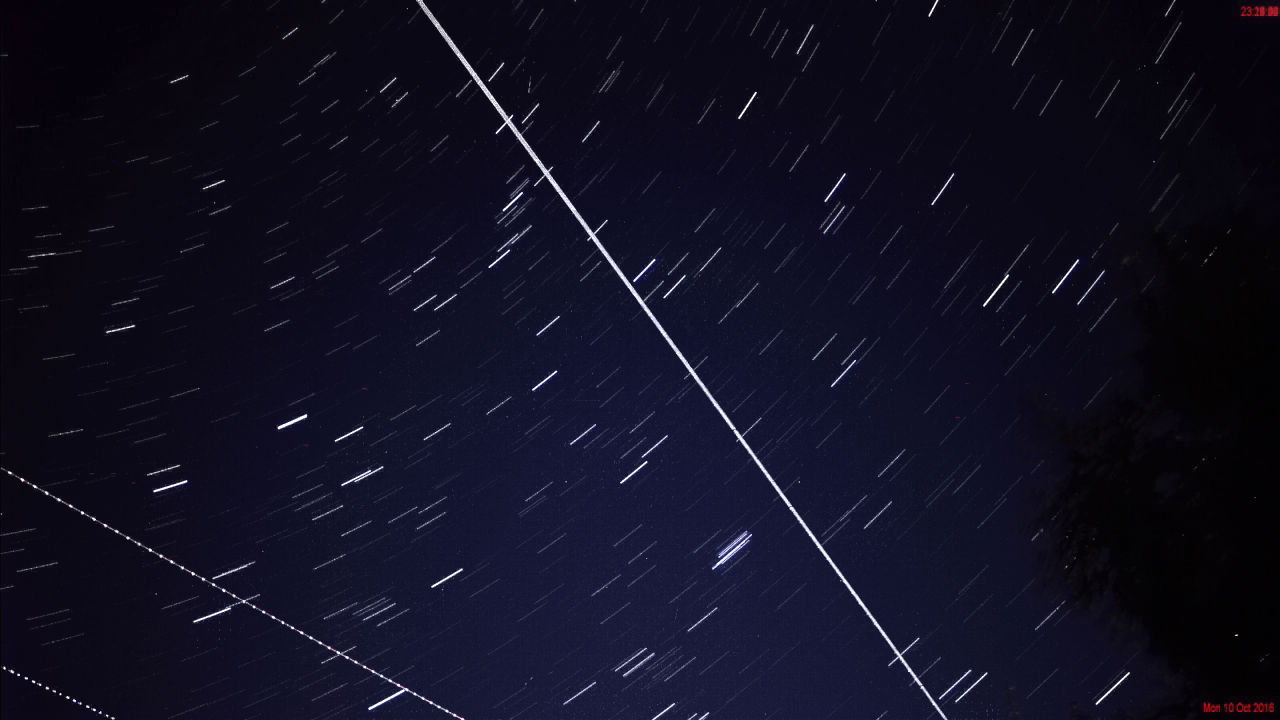

In [ ]:
# +1 star trail készítés
star_trail = create_star_trail('videos/sample.mp4')
cv2_imshow(star_trail)